In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#torch.device('cpu')

In [3]:

# Get transforms
train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

test_data_1_dir = 'data4model_1/test/'
test_data_2_dir = 'data4model_2/test/'
train_data_1_dir = 'data4model_1/train/'
train_data_2_dir = 'data4model_2/train/'

# Load data set
dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=val_transform)
dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=val_transform)
additional_set = datasets.ImageFolder('data4model_1/for_extra_test/',transform=val_transform)



additional_loader = DataLoader(additional_set, shuffle=False, batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

dataSets =  {"Model_1:Train": train_loader_1,
        "Model_1:Test": test_loader_1,
        "Model_2:Train": train_loader_2,
        "Model_2:Test": test_loader_2,
        "Model_1:additional_set": additional_loader
        }

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_11460\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [6]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9283333333333333
F1 Score:  0.9271926854046733
confusion Matrix: 
 [[1416   84]
 [ 131 1369]]


Model_1:Test
Accuracy:  0.87
F1 Score:  0.8617021276595744
confusion Matrix: 
 [[93  7]
 [19 81]]


Model_2:Train
Accuracy:  0.9436666666666667
F1 Score:  0.9452188006482982
confusion Matrix: 
 [[1373  127]
 [  42 1458]]


Model_2:Test
Accuracy:  0.89
F1 Score:  0.8981481481481481
confusion Matrix: 
 [[81 19]
 [ 3 97]]


Model_1:additional_set
Accuracy:  0.723422860712055
F1 Score:  0.7165172855313701
confusion Matrix: 
 [[2993 1007]
 [1207 2798]]




In [6]:
activation_values = {"Model_1":{},
                        "Model_2":{}}

In [7]:
def get_activation(name, model_name):
    def hook(model, input, output):
        
        if name == last_layer_name:
            activation_values[model_name][name] = output.detach()  
            activation_values[model_name][f"{name}_softmax"] = torch.nn.functional.softmax(output.detach(), dim=1) 
        else:
            activation_values[model_name][name] = output.detach()
    return hook

def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0

    last_linear_name = None
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            last_linear_name = name
    
    global last_layer_name
    last_layer_name = last_linear_name

    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            #hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear):
                layer_info[name] = {'type': f'{counter:02}-linear',}
                if name == last_linear_name:
                    layer_info[f"{name}_softmax"] = {'type': f'{counter:02}-softmax'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d):
                layer_info[name] = {'type': f'{counter:02}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.ReLU):
            #      layer_info[name] = {'type': f'{counter}-relu'}
            #      hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.MaxPool2d):
            #     layer_info[name] = {'type': f'{counter}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            # elif isinstance(layer, nn.Flatten):
            #     layer_info[name] = {'type': f'{counter}-flatten'}
            # elif isinstance(layer, nn.BatchNorm2d):
            #     layer_info[name] = {'type': f'{counter}-batchnorm'}
            # elif isinstance(layer, nn.AdaptiveAvgPool2d):
            #     layer_info[name] = {'type': f'{counter}-adaptiveavgpool'}
            # elif isinstance(layer, nn.Softmax):
            #     layer_info[name] = {'type': f'{counter}-softmax'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info


def analyze_positive_activations(activations1, 
                                 activations2,
                                 layers1,
                                 layers2, 
                                 pic_index, 
                                 the_class,
                                 model1_name="Model 1", 
                                 model2_name="Model 2"
                                 ):
    def get_layer_stats(activations, layers):
        layer_stats = {}
        for layer_name, layer_data in layers.items():
            activation = activations[layer_name]
            flattened = activation.view(activation.shape[0], -1)
            positive_activations = flattened[flattened > 0]
            
            stats = {
                'count': len(positive_activations),
                'total_neurons': flattened.numel(),
                'percentage_active': (len(positive_activations) / flattened.numel()) * 100,
                'mean': positive_activations.mean().item() if len(positive_activations) > 0 else 0,
                'sum': positive_activations.sum().item(),
                'max': positive_activations.max().item() if len(positive_activations) > 0 else 0,
                'min': positive_activations.min().item() if len(positive_activations) > 0 else 0,
                'variance': positive_activations.var().item() if len(positive_activations) > 1 else 0
            }
            layer_stats[layers[layer_name]["type"]+" "+layer_name.split(".")[0]] = stats

        return layer_stats

    # Get stats for both models
    stats1 = get_layer_stats(activations1,layers1)
    stats2 = get_layer_stats(activations2,layers2)

    # Create combined DataFrame
    combined_stats = {}
    for layer_name in stats1.keys():
        combined_stats[layer_name] = {
            f'data_index':pic_index,
            f'count_{model1_name}': stats1[layer_name]['count'],
            f'count_{model2_name}': stats2[layer_name]['count'],
            f'total_neurons_{model1_name}': stats1[layer_name]['total_neurons'],
            f'total_neurons_{model2_name}': stats2[layer_name]['total_neurons'],
            f'percentage_active_{model1_name}': stats1[layer_name]['percentage_active'],
            f'percentage_active_{model2_name}': stats2[layer_name]['percentage_active'],
            f'mean_{model1_name}': stats1[layer_name]['mean'],
            f'mean_{model2_name}': stats2[layer_name]['mean'],
            f'sum_{model1_name}': stats1[layer_name]['sum'],
            f'sum_{model2_name}': stats2[layer_name]['sum'],
            f'max_{model1_name}': stats1[layer_name]['max'],
            f'max_{model2_name}': stats2[layer_name]['max'],
            f'min_{model1_name}': stats1[layer_name]['min'],
            f'min_{model2_name}': stats2[layer_name]['min'],
            f'variance_{model1_name}': stats1[layer_name]['variance'],
            f'variance_{model2_name}': stats2[layer_name]['variance'],
            'class': the_class
        }

    df_combined = pd.DataFrame.from_dict(combined_stats, orient='index')
    
    return df_combined

In [52]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [53]:
the_class = 0 # 0 cat or squirrel, 1 dog

In [54]:
with torch.no_grad():
    images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:additional_set"].dataset) 
                if label == the_class and model_1(img.unsqueeze(0).to(DEVICE))
                                          .argmax().item() == the_class]

all_dfs = []

for image, pic_index in images:
    activation_values = {"Model_1":{},
                        "Model_2":{}}

    hooks1, layers1 = register_hooks(model_1, "Model_1")
    hooks2, layers2 = register_hooks(model_2, "Model_2")

    with torch.no_grad():
        pred1 = model_1(image.unsqueeze(0).to(DEVICE))
        pred2 = model_2(image.unsqueeze(0).to(DEVICE))
        

    df_combined = analyze_positive_activations(
        activation_values["Model_1"], 
        activation_values["Model_2"],
        layers1,
        layers2,
        pic_index,
        the_class,
        "Model_1",
        "Model_2"
        
    )
    
    # Add to list
    all_dfs.append(df_combined)
    print('\r ',"pic_index: ", pic_index,end="")

    # Remove hooks
    for hook in hooks1 + hooks2:
        hook.remove()

  pic_index:  3998

In [55]:
# Concatenate all DataFrames 
combined_df = pd.concat(all_dfs, axis=0)
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index': 'layer_name'})

combined_df.to_csv(f'model_comparison_stats_on_{classes[the_class]}.csv', index=False)
combined_df

,layer_name,data_index,count_Model_1,count_Model_2,total_neurons_Model_1,total_neurons_Model_2,percentage_active_Model_1,percentage_active_Model_2,mean_Model_1,mean_Model_2,sum_Model_1,sum_Model_2,max_Model_1,max_Model_2,min_Model_1,min_Model_2,variance_Model_1,variance_Model_2,class
0,02-conv features,0,170311,336796,1605632,1605632,10.607101,20.975915,0.043539,0.043472,7415.210449,14641.181641,0.687363,0.654281,3.725290e-09,1.043081e-07,0.002530,0.001527,0
1,06-conv features,0,97368,55036,802816,802816,12.128308,6.855369,0.062296,0.044247,6065.615234,2435.164795,1.394850,0.826982,1.721084e-06,6.817281e-07,0.006657,0.002793,0
2,10-conv features,0,11485,18851,401408,401408,2.861179,4.696219,0.036813,0.033450,422.793732,630.563660,0.910157,0.499646,2.877787e-06,1.738925e-06,0.001575,0.001557,0
3,16-linear classifier,0,53,39,512,512,10.351562,7.617188,1.125131,1.064249,59.631935,41.505722,3.583178,3.735813,5.856855e-02,2.299808e-02,0.545444,0.742374,0
4,19-linear classifier,0,1,1,2,2,50.000000,50.000000,2.512526,1.694254,2.512526,1.694254,2.512526,1.694254,2.512526e+00,1.694254e+00,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17953,06-conv features,3998,113496,67701,802816,802816,14.137237,8.432941,0.067315,0.030640,7639.956055,2074.341309,2.010755,0.818746,8.977950e-07,1.937151e-07,0.018935,0.003257,0
17954,10-conv features,3998,9270,26519,401408,401408,2.309371,6.606495,0.039820,0.027134,369.127350,719.570374,0.837228,0.515154,1.601875e-07,1.319777e-05,0.002721,0.000826,0
17955,16-linear classifier,3998,28,28,512,512,5.468750,5.468750,0.566432,0.920785,15.860092,25.781967,1.681351,2.648901,5.665947e-02,8.576512e-04,0.147757,0.388569,0
17956,19-linear classifier,3998,1,2,2,2,50.000000,100.000000,0.583837,0.028979,0.583837,0.057958,0.583837,0.041208,5.838367e-01,1.674945e-02,0.000000,0.000299,0



Grouped Statistics by Layer:
                       percentage_active_Model_1  percentage_active_Model_2  \
layer_name                                                                    
02-conv features                          9.3573                    14.4258   
06-conv features                         12.4394                     7.5401   
10-conv features                          2.9600                     5.9019   
16-linear classifier                      5.8609                     7.5023   
19-linear classifier                     50.1838                    49.9332   
19-softmax classifier                   100.0000                   100.0000   

                       mean_Model_1  mean_Model_2  sum_Model_1  sum_Model_2  \
layer_name                                                                    
02-conv features             0.0526        0.0553    7954.5782   12793.8508   
06-conv features             0.0656        0.0349    6592.4112    2100.9122   
10-conv features     

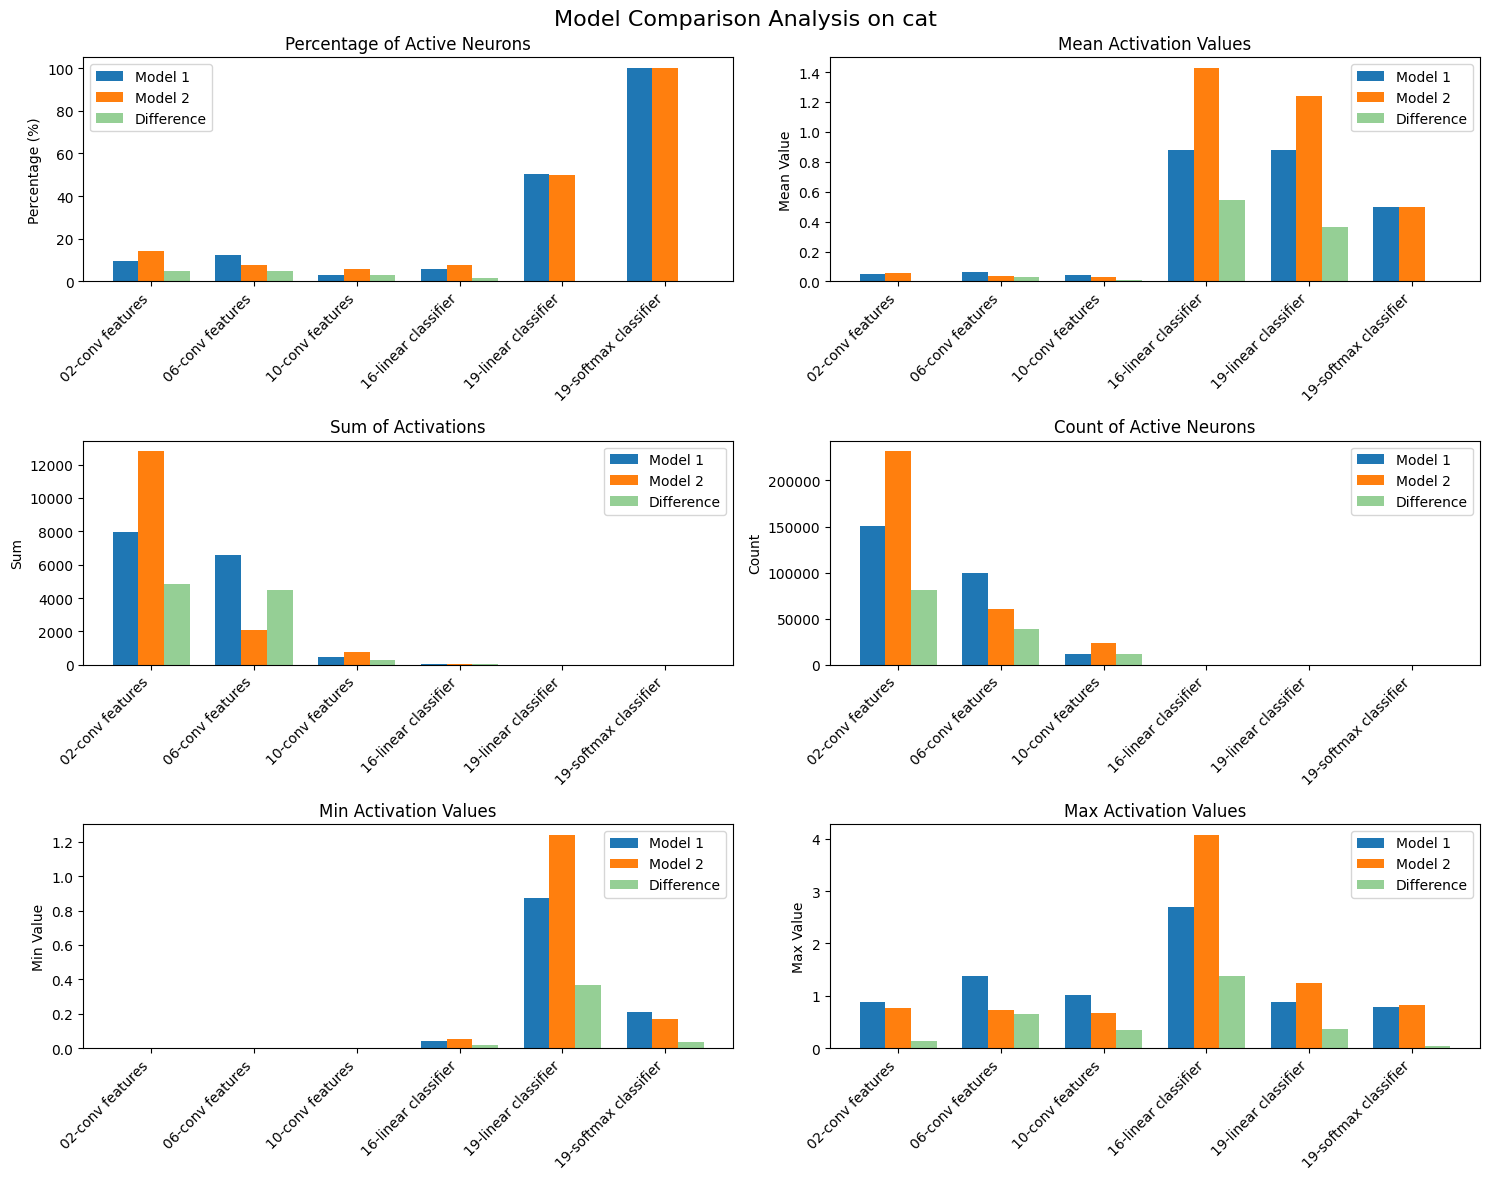


Numerical Differences (Model 2 - Model 1):

Layer: 02-conv features
Percentage Active Difference: 5.07%
Mean Activation Difference: 0.0027
Sum Activation Difference: 4839.27
Active Neuron Count Difference: 81382

Layer: 06-conv features
Percentage Active Difference: -4.90%
Mean Activation Difference: -0.0308
Sum Activation Difference: -4491.50
Active Neuron Count Difference: -39332

Layer: 10-conv features
Percentage Active Difference: 2.94%
Mean Activation Difference: -0.0087
Sum Activation Difference: 281.14
Active Neuron Count Difference: 11809

Layer: 16-linear classifier
Percentage Active Difference: 1.64%
Mean Activation Difference: 0.5471
Sum Activation Difference: 29.49
Active Neuron Count Difference: 8

Layer: 19-linear classifier
Percentage Active Difference: -0.25%
Mean Activation Difference: 0.3661
Sum Activation Difference: 0.36
Active Neuron Count Difference: -0

Layer: 19-softmax classifier
Percentage Active Difference: 0.00%
Mean Activation Difference: -0.0000
Sum Acti

In [56]:
df = pd.read_csv(f'model_comparison_stats_on_{classes[the_class]}.csv')

grouped = df.groupby('layer_name').mean()

print("\nGrouped Statistics by Layer:")
print("=" * 100)
print(grouped[['percentage_active_Model_1', 'percentage_active_Model_2', 
               'mean_Model_1', 'mean_Model_2',
               'sum_Model_1', 'sum_Model_2',
               'count_Model_1', 'count_Model_2',
               'min_Model_1','min_Model_2',
                'max_Model_1','max_Model_2']].round(4))

# save the grouped statistics
grouped.to_csv(f'model_comparison_grouped_stats_on_{classes[the_class]}.csv')

layers = grouped.index
width = 0.25

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Model Comparison Analysis on {classes[the_class]}', fontsize=16)

# 1. Percentage of Active Neurons
ax1 = axes[0, 0]
x = np.arange(len(layers))
ax1.bar(x - width, grouped['percentage_active_Model_1'], width, label='Model 1')
ax1.bar(x, grouped['percentage_active_Model_2'], width, label='Model 2')
ax1.bar(x + width, abs(grouped['percentage_active_Model_2'] - grouped['percentage_active_Model_1']), 
        width, label='Difference', alpha=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(layers, rotation=45, ha='right')
ax1.set_title('Percentage of Active Neurons')
ax1.set_ylabel('Percentage (%)')
ax1.legend()

# 2. Mean Activation Values
ax2 = axes[0, 1]
ax2.bar(x - width, grouped['mean_Model_1'], width, label='Model 1')
ax2.bar(x, grouped['mean_Model_2'], width, label='Model 2')
ax2.bar(x + width, abs(grouped['mean_Model_2'] - grouped['mean_Model_1']), 
        width, label='Difference', alpha=0.5)
ax2.set_xticks(x)
ax2.set_xticklabels(layers, rotation=45, ha='right')
ax2.set_title('Mean Activation Values')
ax2.set_ylabel('Mean Value')
ax2.legend()

# 3. Sum of Activations
ax3 = axes[1, 0]
ax3.bar(x - width, grouped['sum_Model_1'], width, label='Model 1')
ax3.bar(x, grouped['sum_Model_2'], width, label='Model 2')
ax3.bar(x + width, abs(grouped['sum_Model_2'] - grouped['sum_Model_1']), 
        width, label='Difference', alpha=0.5)
ax3.set_xticks(x)
ax3.set_xticklabels(layers, rotation=45, ha='right')
ax3.set_title('Sum of Activations')
ax3.set_ylabel('Sum')
ax3.legend()

# 4. Count of Active Neurons
ax4 = axes[1, 1]
ax4.bar(x - width, grouped['count_Model_1'], width, label='Model 1')
ax4.bar(x, grouped['count_Model_2'], width, label='Model 2')
ax4.bar(x + width, abs(grouped['count_Model_2'] - grouped['count_Model_1']), 
        width, label='Difference', alpha=0.5)
ax4.set_xticks(x)
ax4.set_xticklabels(layers, rotation=45, ha='right')
ax4.set_title('Count of Active Neurons')
ax4.set_ylabel('Count')
ax4.legend()


# 5. Min Activation Values
ax5 = axes[2, 0]
ax5.bar(x - width, grouped['min_Model_1'], width, label='Model 1')
ax5.bar(x, grouped['min_Model_2'], width, label='Model 2')
ax5.bar(x + width, abs(grouped['min_Model_2'] - grouped['min_Model_1']), 
        width, label='Difference', alpha=0.5)
ax5.set_xticks(x)
ax5.set_xticklabels(layers, rotation=45, ha='right')
ax5.set_title('Min Activation Values')
ax5.set_ylabel('Min Value')
ax5.legend()

# 6. Max Activation Values
ax6 = axes[2, 1]
ax6.bar(x - width, grouped['max_Model_1'], width, label='Model 1')
ax6.bar(x, grouped['max_Model_2'], width, label='Model 2')
ax6.bar(x + width, abs(grouped['max_Model_2'] - grouped['max_Model_1']), 
        width, label='Difference', alpha=0.5)
ax6.set_xticks(x)
ax6.set_xticklabels(layers, rotation=45, ha='right')
ax6.set_title('Max Activation Values')
ax6.set_ylabel('Max Value')
ax6.legend()

plt.tight_layout()
save_path = f'model_comparison_analysis_on_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300)
plt.show()

# Print numerical differences
print("\nNumerical Differences (Model 2 - Model 1):")
print("=" * 80)
for layer in layers:
    print(f"\nLayer: {layer}")
    print(f"Percentage Active Difference: {grouped['percentage_active_Model_2'][layer] - grouped['percentage_active_Model_1'][layer]:.2f}%")
    print(f"Mean Activation Difference: {grouped['mean_Model_2'][layer] - grouped['mean_Model_1'][layer]:.4f}")
    print(f"Sum Activation Difference: {grouped['sum_Model_2'][layer] - grouped['sum_Model_1'][layer]:.2f}")
    print(f"Active Neuron Count Difference: {grouped['count_Model_2'][layer] - grouped['count_Model_1'][layer]:.0f}")


C:\Users\hskay\AppData\Local\Temp\ipykernel_11460\516922005.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\hskay\AppData\Local\Temp\ipykernel_11460\516922005.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
C:\Users\hskay\AppData\Local\Temp\ipykernel_11460\516922005.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
C:\Users\hskay\AppData\Local\Temp\ipykernel_11460\516922005.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_

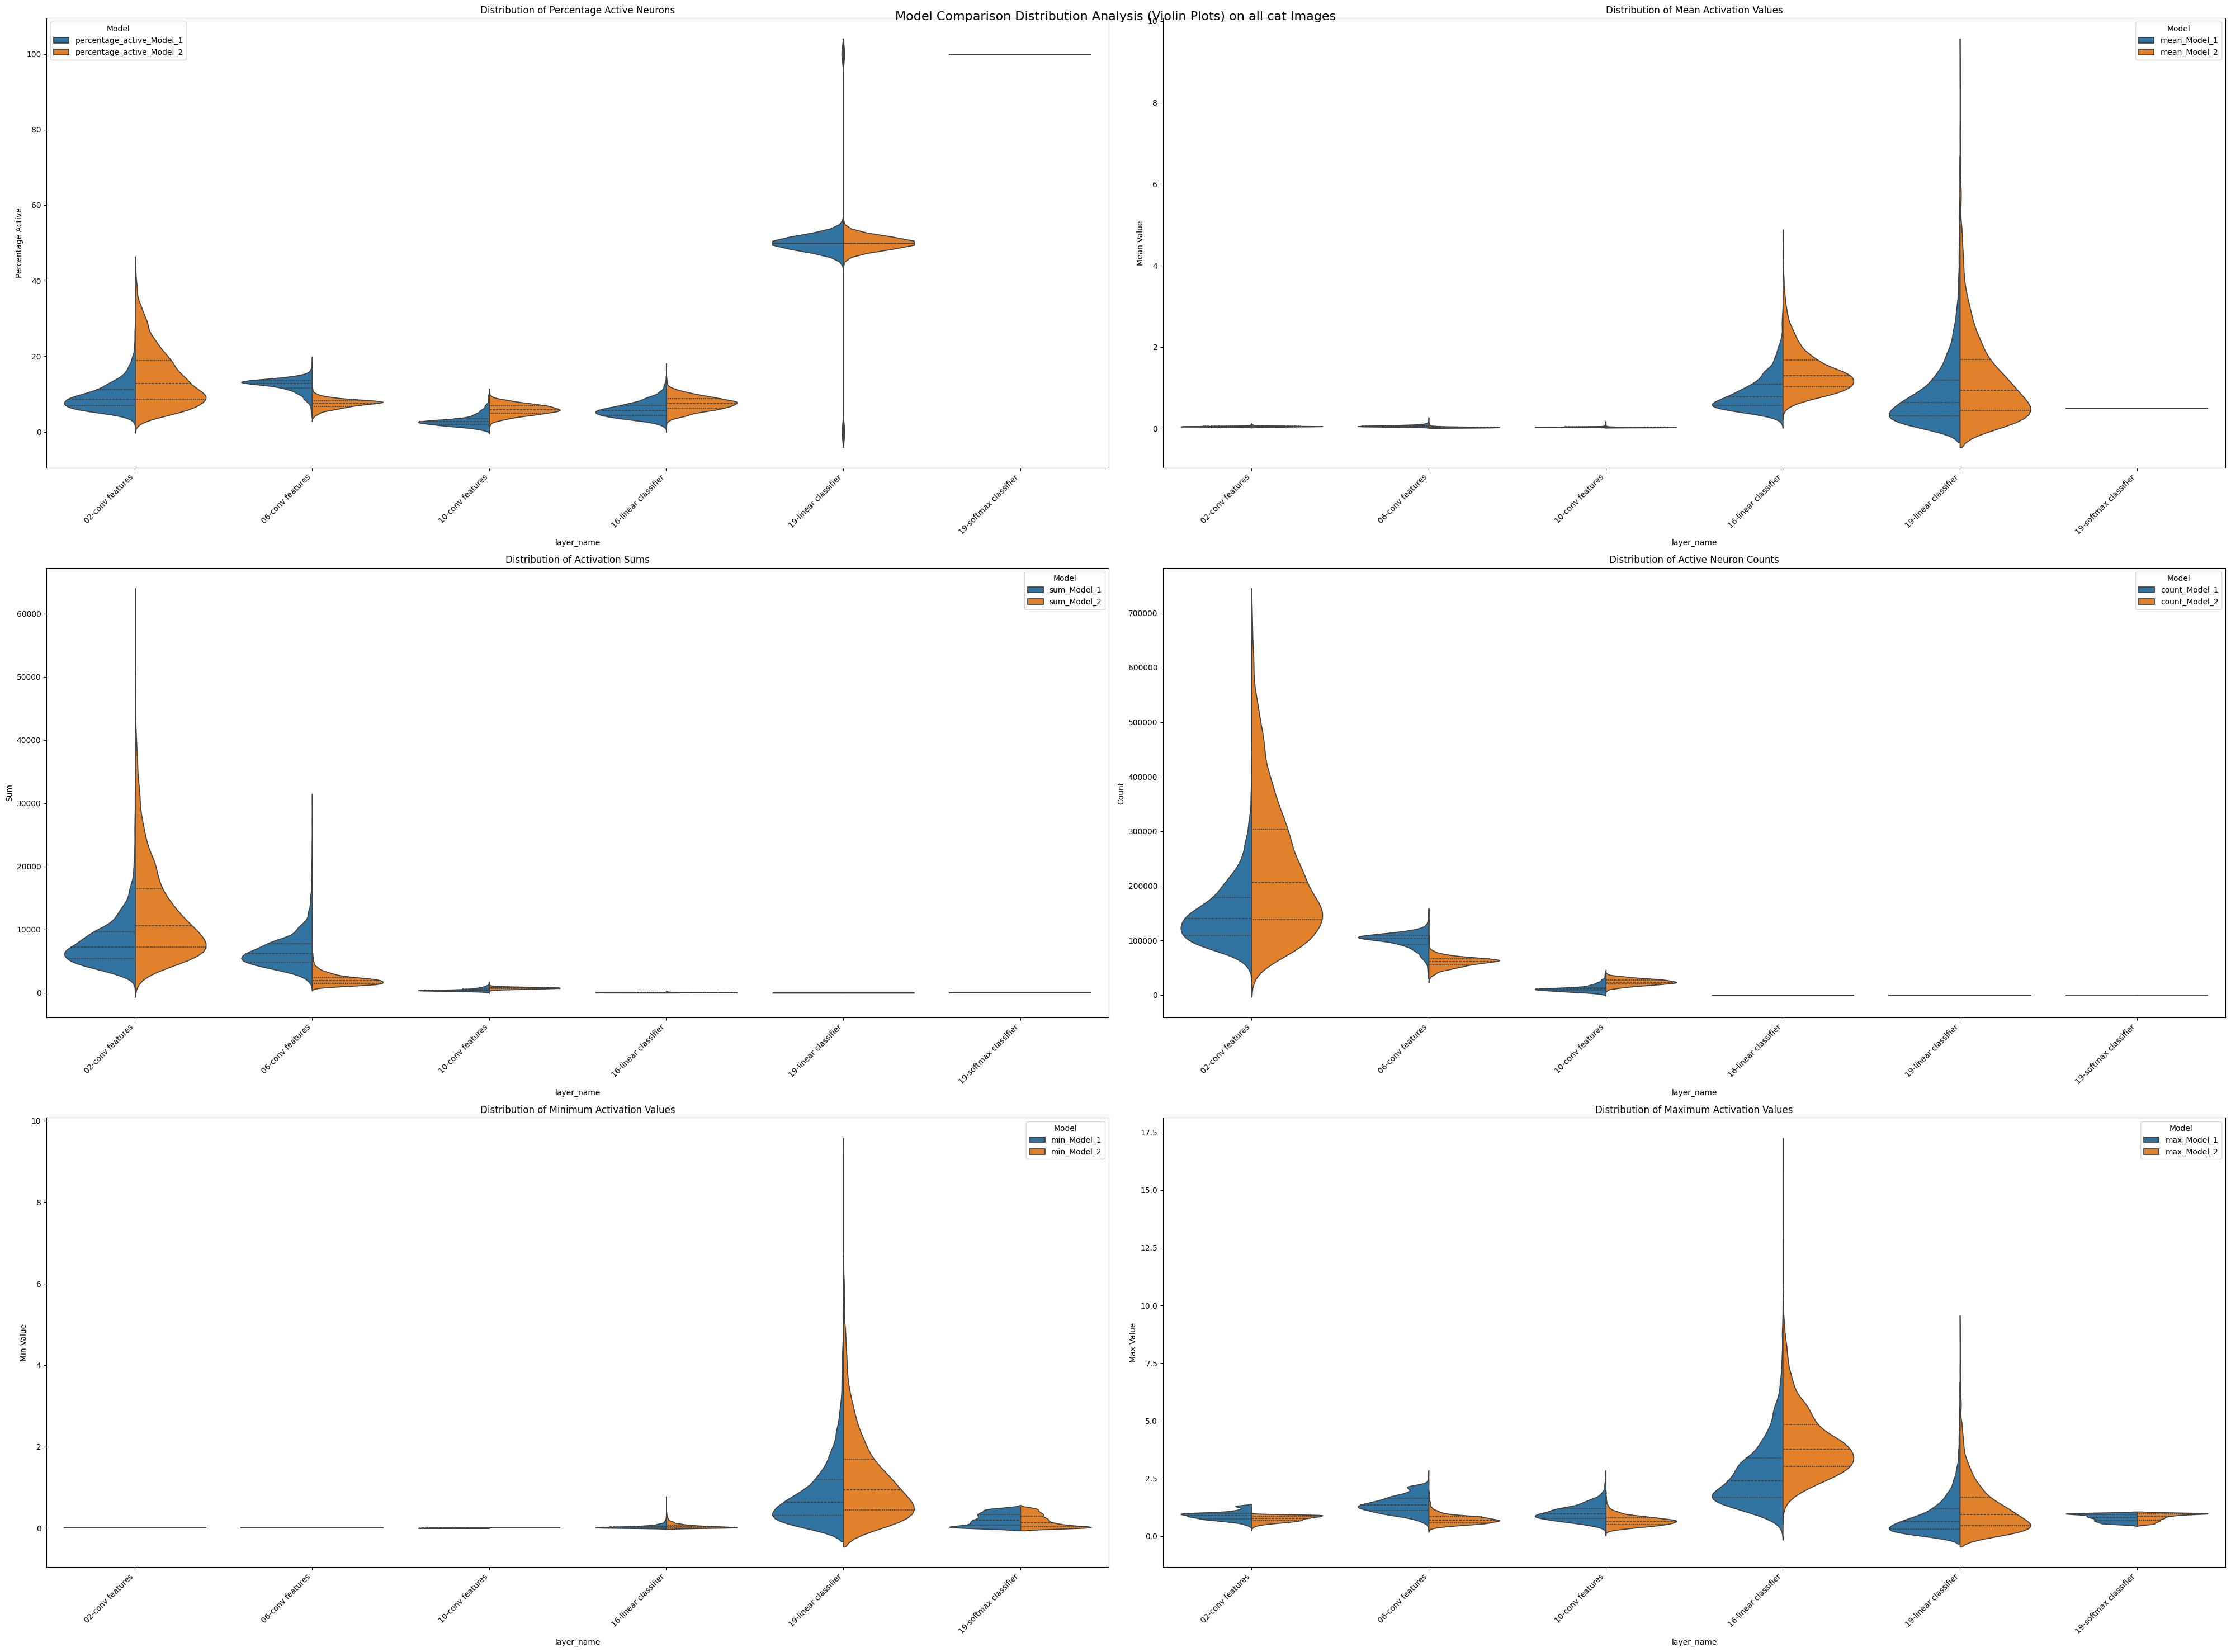

In [57]:
# Create a figure for violin plots
fig, axes = plt.subplots(3, 2, figsize=(40, 30))
fig.suptitle(f'Model Comparison Distribution Analysis (Violin Plots) on all {classes[the_class]} Images', fontsize=16)

# 1. Percentage Active Distribution
ax1 = axes[0, 0]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['percentage_active_Model_1', 'percentage_active_Model_2'],
                    var_name='Model', value_name='Percentage Active')
sns.violinplot(data=df_melted, x='layer_name', y='Percentage Active', 
               hue='Model', 
               split=True, 
               ax=ax1, 
               inner='quartile',
               density_norm='count',
               )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Distribution of Percentage Active Neurons')

# 2. Mean Values Distribution
ax2 = axes[0, 1]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['mean_Model_1', 'mean_Model_2'],
                    var_name='Model', value_name='Mean Value')
sns.violinplot(data=df_melted, x='layer_name', y='Mean Value', 
               hue='Model',
               split=True, 
               ax=ax2, 
               inner='quartile',
               density_norm='count',
               )
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Distribution of Mean Activation Values')

# 3. Sum Distribution
ax3 = axes[1, 0]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['sum_Model_1', 'sum_Model_2'],
                    var_name='Model', value_name='Sum')
sns.violinplot(data=df_melted, x='layer_name', y='Sum', 
               hue='Model', split=True, ax=ax3 ,inner='quartile',
               density_norm='count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.set_title('Distribution of Activation Sums')

# 4. Count Distribution
ax4 = axes[1, 1]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['count_Model_1', 'count_Model_2'],
                    var_name='Model', value_name='Count')
sns.violinplot(data=df_melted, x='layer_name', y='Count', 
               hue='Model', split=True, ax=ax4,inner='quartile',
               density_norm='count')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_title('Distribution of Active Neuron Counts')

# 5. Min Values Distribution
ax5 = axes[2, 0]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['min_Model_1', 'min_Model_2'],
                    var_name='Model', value_name='Min Value')
sns.violinplot(data=df_melted, x='layer_name', y='Min Value', 
               hue='Model', split=True, ax=ax5,inner='quartile',
               density_norm='count')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.set_title('Distribution of Minimum Activation Values')

# 6. Max Values Distribution
ax6 = axes[2, 1]
df_melted = pd.melt(df, 
                    id_vars=['layer_name'],
                    value_vars=['max_Model_1', 'max_Model_2'],
                    var_name='Model', value_name='Max Value')
sns.violinplot(data=df_melted, x='layer_name', y='Max Value', 
               hue='Model', split=True, ax=ax6,inner='quartile',
               density_norm='count')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
ax6.set_title('Distribution of Maximum Activation Values')

# Adjust layout
plt.tight_layout()
save_path = f'model_comparison_violin_plots_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300)
plt.show()